In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()
backend = provider.get_backend('ibm_torino')
# backend = provider.get_backend('ibm_sherbrooke')

In [3]:
from Scratch import metadata_loader

md = metadata_loader(True, True)

md = md[md["notebook_name"]=='Torino_RepCodes_jobs']
# md = md[md["notebook_name"]=='Sherbrooke_RepCodes_jobs']

md = md[md["job_status"] == "JobStatus.DONE"]
md.dropna(subset=['xbasis', 'logical', 'rounds'], inplace=True)

print("shape before", md.shape)

unique_jobs = md.drop_duplicates(subset=['xbasis', 'logical', 'rounds'], keep='first')
# unique_jobs
print("shape after", unique_jobs.shape)

shape before (549, 28)
shape after (28, 28)


In [14]:
from tqdm import tqdm
import numpy as np

from soft_info import EvaluateBottlenecks

md_s = md
md_s = md_s[::-1]

# md_s = unique_jobs


differences = {
    "mean_gate": [],
    "min_gate": [],
    "max_gate": [],
    "mean_r": [],
    "min_r": [],
    "max_r": [],
    "mean_an": [],
    "min_an": [],
    "max_an": [],
    "fid": []
}

for job_id in tqdm(md_s["job_id"]):
    job = provider.retrieve_job(job_id)
    layout = job.initial_layouts()[0]
    layout_des = job.deserialize_layout(layout) 
    link_qubits = list(layout_des["link_qubit"].values())
    code_qubits = list(layout_des["code_qubit"].values())
    path = [index for tpl in zip(code_qubits, link_qubits) for index in tpl]

    # Get the path_info in md of that job
    md_entry = md[md["job_id"] == job_id]
    execution_date = md_entry["execution_date"].values[0]
    path_info = md_entry["path_info"].values[0]

    evaluator = EvaluateBottlenecks(backend, date=execution_date)
    error_info = evaluator.get_error_info(path=path)
    path_info_values = path_info.values()

    # Calculate and accumulate differences for each metric
    for (metric, (value, path_value)) in zip(differences.keys(), zip(error_info, path_info_values)):
        differences[metric].append(abs(value - path_value))
    


# Calculate mean difference for each metric
mean_differences = {metric: np.mean(diffs) for metric, diffs in differences.items()}

100%|██████████| 549/549 [34:37<00:00,  3.78s/it]


In [19]:
print(f"For device {backend.name}:")


# Print mean differences
for metric, mean_diff in mean_differences.items():
    print(f"Mean difference for {metric}: {mean_diff*100:.3f} %")

print()
# Print max differences
max_differences = {metric: np.max(diffs) for metric, diffs in differences.items()}
for metric, max_diff in max_differences.items():
    print(f"Max difference for {metric}: {max_diff*100:.3f} %")

    

For device ibm_torino:
Mean difference for mean_gate: 0.000 %
Mean difference for min_gate: 0.000 %
Mean difference for max_gate: 0.000 %
Mean difference for mean_r: 0.042 %
Mean difference for min_r: 0.012 %
Mean difference for max_r: 3.478 %
Mean difference for mean_an: 0.031 %
Mean difference for min_an: 0.009 %
Mean difference for max_an: 0.077 %
Mean difference for fid: 0.329 %

Max difference for mean_gate: 0.001 %
Max difference for min_gate: 0.000 %
Max difference for max_gate: 0.000 %
Max difference for mean_r: 0.374 %
Max difference for min_r: 0.110 %
Max difference for max_r: 32.360 %
Max difference for mean_an: 0.139 %
Max difference for min_an: 0.080 %
Max difference for max_an: 0.720 %
Max difference for fid: 0.329 %


In [20]:
# Save the differences
import json

with open(f'differences_{backend.name}.json', 'w') as f:
    json.dump(differences, f)

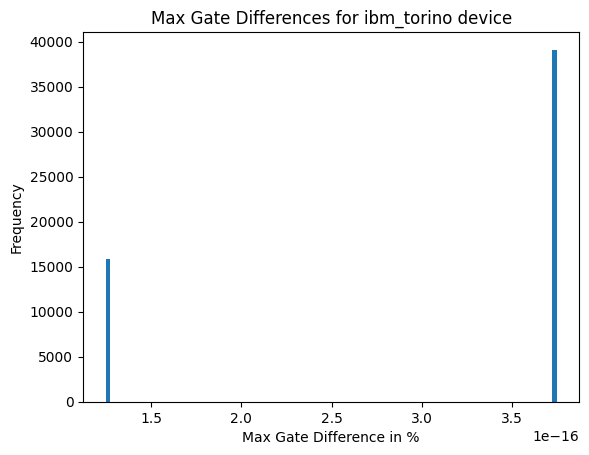

In [21]:
# plot the max_gate_differences histogram
import matplotlib.pyplot as plt

plt.hist(differences["max_gate"]*100, bins=100)
plt.title(f"Max Gate Differences for {backend.name} device")
plt.xlabel("Max Gate Difference in %")
plt.ylabel("Frequency")
plt.show()


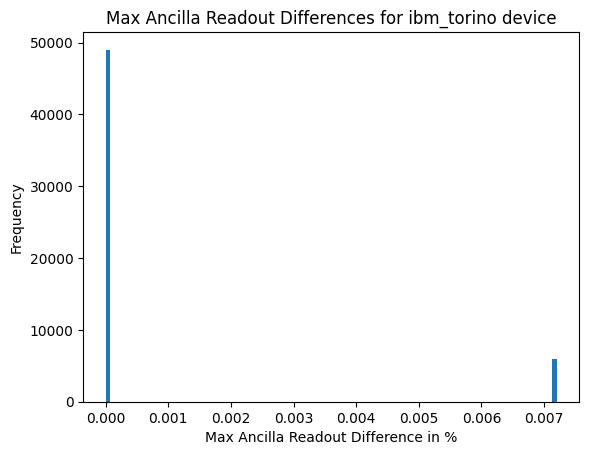

In [23]:
# plot the max_an_differences histogram
plt.hist(differences["max_an"]*100, bins=100)
plt.title(f"Max Ancilla Readout Differences for {backend.name} device")
plt.xlabel("Max Ancilla Readout Difference in %")
plt.ylabel("Frequency")
plt.show()
